In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [3]:
CSV_PATH="../../../data/processed/03_processed_data/only_frontal_labels_filtered.csv"
IMAGE_DIR="../../../data/processed/03_processed_data/only_frontal_images"
RESULT_DIR="../../../src/results"  # 저장 경로
os.makedirs(RESULT_DIR, exist_ok=True)
df=pd.read_csv(CSV_PATH)
df.head(2)

,filename,male,female,0s,10s,20s,30s,40s,50s,60+
0,F0001_IND_D_18_0_01.JPG,0,1,0,1,0,0,0,0,0
1,F0001_IND_D_18_0_02.JPG,0,1,0,1,0,0,0,0,0


In [4]:
train_df, test_df=train_test_split(df, test_size=0.1, random_state=SEED, shuffle=True)
train_df, val_df=train_test_split(train_df, test_size=0.1, random_state=SEED, shuffle=True)

print(train_df.shape, val_df.shape, test_df.shape)

(23588, 10) (2621, 10) (2913, 10)


# 전처리

> ### Keras VS PyTorch
>- Keras(ImageDataGenerator)
>    - 경로만 지정하면 내부에서 알아서 자동으로 로드
>    - 내부에서 증강 적용
>    - 내부에서 batch_size 지정
>    - x_col, y_col 옵션으로 라벨 처리 자동화
>- PyTorch(Dataset + DataLoader)
>    - Dataset 클래스 지정 후 상속해서 직접 로드하는 과정 정의 필요
>    - __getitem__에서 직접 이미지 로딩
>    - `transforms.Compose()` 로 증강
>    - DataLoader로 shuffle, batch_size 지정
>    - __getitem__에서 직접 라벨 추출
>
>즉 기존 Keras에서는 다음과 같이 지정했는데,
>```python
>train_datagen=ImageDataGenerator(rescale=1/255.0)
>train_generator=train_datagen.flow_from_dataframe(
>    dataframe=train_df,
>    directory=IMAGE_DIR,
>    x_col="filename",
>    y_col=LABEL_COLS,
>    target_size=(224, 224),
>    batch_size=16,
>    class_mode="raw",
>    shuffle=True
>)
>```  
> 
>PyTorch에서는 데이터 처리 및 학습 까지 사용하가 위한 데이터 파이프라인을 구축하는데 사용되는 Dataset과 DataLoader 클래스를 사용해야 한다.  
>Dataset 클래스를 통해 데이터 로드 및 전처리를,
>DataLoader 클래스를 통해 모델 학습에 필요한 데이터를 배치 단위로 처리할 수 있도록 한다.  
>
>사용자는 이 Dataset 클래스를 상속받고, 데이터셋에 맞게 클래스를 구현하는 것이다.  
>이때 데이터 셋의 전체 샘플 개수를 반환하는 `len()` 메서드와
>인덱스에 해당하는 샘플을 가져오도록 하는 `getitem(idx)` 메서드를 구현해야 한다.  
>
>그리고 모델 학습 시에 데이터를 배치 단위로 로드하는 클래스에는 다음과 같은 기능들을 지정해준다.  
>- dataset
>- batch_size (default: 1)
>- shuffle (default: False)
>- num_workers: 병렬 처리 사용할 때 사용 (default: 0)
>- pin_memory: GPU 메모리에 데이터를 고정할지 여부 지정 -> GPU 사용할 경우 True로 설정하면 데이터가 CPU와 GPU 간에 더 빠르게 복사되어 학습 속도를 향상시킴 (default: False)
>- collate_fn: 배치 생성 전 데이터를 결합하는 함수 지정
>- drop_last: 마지막 배치의 크기가 batch_size보다 작으면 해당 배치를 무시할지 여부 결정 (default: False)
>
>코드로는 아래부터 보자.  

In [5]:
BATCH_SIZE=16
IMAGE_SIZE=(224, 224)
LABEL_COLS=["male","female","0s","10s","20s","30s","40s","50s","60+"]

In [6]:
# Dataset 클래스
class AgeSexDataset(Dataset):
    def __init__(self, image_dir, dataframe, transform=None):
        self.image_dir=image_dir
        self.dataframe=dataframe.reset_index(drop=True)
        self.transform=transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path=os.path.join(self.image_dir, self.dataframe.loc[idx, "filename"])
        # L: 흑백 / RGBA: 투명(PNG) / RGB: 컬러 -> 자동 적용됨 but 흑백, 투명 오류 예방용으로 .convert()
        image=Image.open(img_path).convert("RGB")

        # PyTorch 텐서는 float32가 표준
        # 또한 다중 이진 분류(BCEWithLogitsLoss)는 float 타입 기대
        # astype(np.float32)로 변환 후 torch.tensor(label) 적용하는 게 정석
        label=self.dataframe.loc[idx, LABEL_COLS].values.astype(np.float32)

        if self.transform:
            image=self.transform(image)

        return image, torch.tensor(label)

# 이미지 전처리
transform=transforms.Compose([
    # PyTorch Tensor 변환 필수
    # ToTensor(): PIL 이미지 또는 numpy 배열을 pytorch tensor로 변화 시켜주는 클래스
    # H, W, C (PIL) -> C, H, W (PyTorch) & 픽셀값 0~255 -> 0~1로 정규화
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

train_dataset=AgeSexDataset(IMAGE_DIR, train_df, transform)
val_dataset=AgeSexDataset(IMAGE_DIR, val_df, transform)
test_dataset=AgeSexDataset(IMAGE_DIR, test_df, transform)

# DataLoader 클래스
train_loader=DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader=DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader=DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 모델

In [7]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
EPOCHS=20
LEARNING_RATE=0.0001

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Feature Map 뽑기
        # Conv2D -> 필터로 특징 추출
        # ReLU -> 비선형성 추가
        # MaxPool2d -> MaxPooling, 다운 샘플링
        self.features=nn.Sequential(
            # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
            # dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
            # in_channel=3(RGB)
            # Keras는 (H, W, C) 순서, PyTorch는 (C, H, W) 순서
            # [PyTorch] in_channels=3 <==> [Keras] input_shape=(H, W, 3) 
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # FullyConnectedLayer
        # nn.Flatten() -> 1차원 벡터 변환
        # nn.Linear -> Dense Layer
        # Dropout -> 과적합 방지
        # 마지막 Linear -> 출력 노드 수 결정 (num_classes 만큼)
        self.classifier=nn.Sequential(  
            nn.Flatten(),
            nn.Linear(64 * (IMAGE_SIZE[0]//8) * (IMAGE_SIZE[1]//8), 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    # 순전파 (직접 작성 필요)
    def forward(self, x): 
        x=self.features(x)
        x=self.classifier(x)
        return x

model=SimpleCNN(num_classes=len(LABEL_COLS)).to(device)

# 손실함수 및 옵티마이저
loss_function=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(), lr=LEARNING_RATE)

# PyTorch 학습 루프 + history 저장

In [9]:
# 학습 기록 리스트
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]

# 최적 모델 저장 기준
# 초기값을 매우 크게 잡아서 첫 번째 val_loss가 무조건 더 작게 만들어 비교 가능
# 최적의 모델 성능을 계속 업데이트할 기준 값
best_val_loss=float("inf")

for epoch in range(EPOCHS):
    model.train()  # PyTorch 내부의 학습 메서드로, Dropout, BatchNormalization 등이 학습용 동작 하도록 설정
    train_loss=0  # 에폭(한 번 전체 데이터 학습) 시작 전 손실 값 초기화
    correct_train=0
    total_train=0
    
    for images, labels in train_loader:
        images, labels=images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # 이전 단계의 gradient 초기화 -> PyTorch는 기본적으로 gradient가 누적됨 -> 매번 초기화 필요
        outputs=model(images)  # 순전파 호출 -> forward() 호출
        loss=loss_function(outputs, labels)  # output과 정답 labels 비교 -> 손실 계산
        loss.backward()  # PyTorch 내부 역전파 자동 실행 -> gradient 계산
        optimizer.step()  # 계산된 gradient를 바탕으로 파라미터 업데이트 -> 한 번의 학습이 실제로 적용되는 단계
        
        train_loss+=loss.item()  # loss는 tensor 형태 -> .item()으로 파이썬 숫자 추출 -> 모든 배치 손실 누적 합산
        
        # 정확도
        # 다중 이진 분류: 전체 라벨이 완벽 일치한 경우만 정답 처리
        preds=torch.sigmoid(outputs)>0.5
        correct_train+=(preds.cpu()==labels.cpu()).all(dim=1).sum().item()
        total_train+=labels.size(0)

    # 평균 손실 계산
    # len(train_loader): 배치 개수
    # epoch 단위로 손실 흐름 모니터링
    avg_train_loss=train_loss/len(train_loader)  
    train_accuracy=correct_train/total_train

    # 검증
    model.eval()  # PyTorch 내부 평가 메서드 -> Dropout 비활성화, BatchNormalization을 평균값, 분산값 고정 사용
    val_loss=0
    correct_val=0
    total_val=0

    with torch.no_grad():  # gradient 기록 비활성화 -> 메모리 사용 줄이고 속도 향상 -> 검증, 테스트, 추론단계에서 필수
        for images, labels in val_loader:
            images, labels=images.to(device), labels.to(device)
            outputs=model(images)
            loss=loss_function(outputs, labels)
            val_loss+=loss.item()  # 검증 손실 계산 로직과 동일 -> 누적
            
            preds=torch.sigmoid(outputs)>0.5
            correct_val+=(preds.cpu()==labels.cpu()).all(dim=1).sum().item()
            total_val+=labels.size(0)

    avg_val_loss=val_loss/len(val_loader)  # 평균 손실 계산
    val_accuracy=correct_val/total_val
    
    # 기록
    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    train_acc_list.append(train_accuracy)
    val_acc_list.append(val_accuracy)

    # 진행 사항 출력용
    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # 현재 모델 파라미터(가중치, 편향 등) 저장
    # state_dict(): 파라미터(가중치, 편향 등) 딕셔너리로 변환
    # 최적 성능일 때만 저장 -> EarlyStopping 같이
    if avg_val_loss<best_val_loss:
        best_val_loss=avg_val_loss
        torch.save(model.state_dict(), "05_simple_cnn_best.pth")  # PyTorch 모델 파라미터 파일

Epoch [1/20] Train Loss: 0.3744, Val Loss: 0.3168
Epoch [2/20] Train Loss: 0.3007, Val Loss: 0.2671
Epoch [3/20] Train Loss: 0.2646, Val Loss: 0.2486
Epoch [4/20] Train Loss: 0.2413, Val Loss: 0.2253
Epoch [5/20] Train Loss: 0.2219, Val Loss: 0.2211
Epoch [6/20] Train Loss: 0.2078, Val Loss: 0.2076
Epoch [7/20] Train Loss: 0.1935, Val Loss: 0.1909
Epoch [8/20] Train Loss: 0.1792, Val Loss: 0.1816
Epoch [9/20] Train Loss: 0.1691, Val Loss: 0.1784
Epoch [10/20] Train Loss: 0.1582, Val Loss: 0.1670
Epoch [11/20] Train Loss: 0.1488, Val Loss: 0.1646
Epoch [12/20] Train Loss: 0.1393, Val Loss: 0.1599
Epoch [13/20] Train Loss: 0.1304, Val Loss: 0.1562
Epoch [14/20] Train Loss: 0.1242, Val Loss: 0.1521
Epoch [15/20] Train Loss: 0.1169, Val Loss: 0.1509
Epoch [16/20] Train Loss: 0.1078, Val Loss: 0.1494
Epoch [17/20] Train Loss: 0.1040, Val Loss: 0.1582
Epoch [18/20] Train Loss: 0.0969, Val Loss: 0.1465
Epoch [19/20] Train Loss: 0.0926, Val Loss: 0.1523
Epoch [20/20] Train Loss: 0.0862, Val Lo

# Loss & Accuracy 그래프

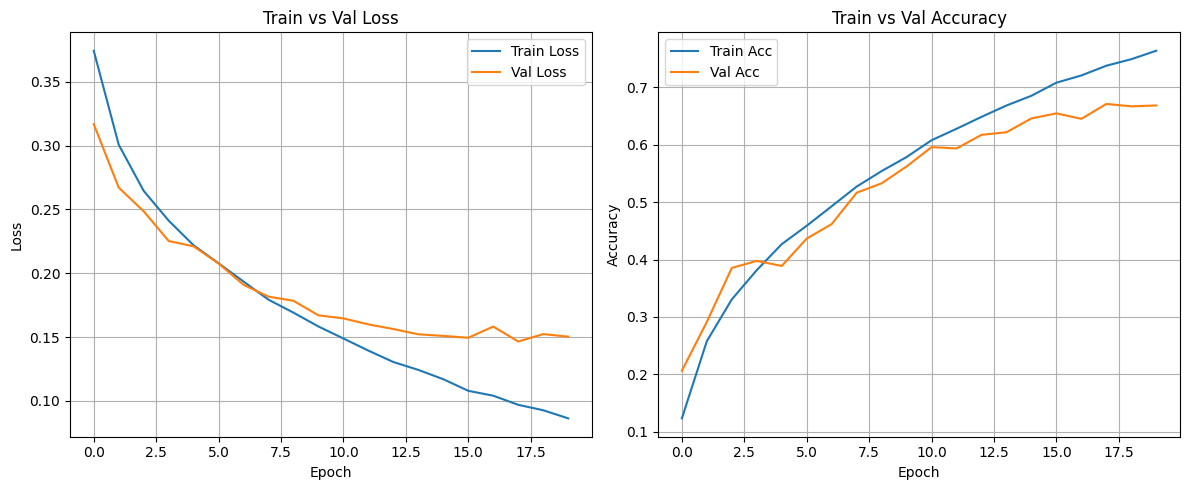

In [10]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.title("Train vs Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.title("Train vs Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, "05_acc_loss_graph.jpg"))
plt.show()

# Classification Report

In [28]:
# 모델 로드
model.load_state_dict(torch.load("05_simple_cnn_best.pth"))
model.eval()

# 전체 데이터 수집
all_images=[]
all_labels=[]
all_preds=[]

with torch.no_grad():
    for images, labels in test_loader:
        images=images.to(device)
        outputs=model(images)
        preds=torch.sigmoid(outputs).cpu().numpy()

        all_images.extend(images.cpu())
        all_labels.extend(labels.numpy())

        # 성별 정리
        sex_preds=preds[:, :2]
        sex_argmax=np.argmax(sex_preds, axis=1)
        sex_result=np.zeros_like(sex_preds)
        sex_result[np.arange(len(sex_preds)), sex_argmax]=1

        # 연령대 정리
        age_preds=preds[:, 2:]
        age_argmax=np.argmax(age_preds, axis=1)
        age_result=np.zeros_like(age_preds)
        age_result[np.arange(len(age_preds)), age_argmax]=1

        clean_preds=np.concatenate([sex_result, age_result], axis=1)
        all_preds.extend(clean_preds)

all_labels=np.array(all_labels)
all_preds=np.array(all_preds)

# Classification Report
report=classification_report(all_labels, all_preds, target_names=LABEL_COLS, digits=4)
print(report)
with open(os.path.join(RESULT_DIR, "05_classification_report_clean.txt"), "w") as f:
    f.write(report)

              precision    recall  f1-score   support

        male     0.9505    0.9788    0.9645      1276
      female     0.9831    0.9603    0.9716      1637
          0s     0.9167    0.2683    0.4151        41
         10s     0.8519    0.9347    0.8914      1102
         20s     0.7216    0.6567    0.6876       367
         30s     0.8197    0.4000    0.5376       125
         40s     0.6647    0.7943    0.7237       559
         50s     0.7169    0.4846    0.5783       324
         60+     0.8537    0.8861    0.8696       395

   micro avg     0.8761    0.8761    0.8761      5826
   macro avg     0.8310    0.7071    0.7377      5826
weighted avg     0.8766    0.8761    0.8712      5826
 samples avg     0.8761    0.8761    0.8761      5826



# 혼동행렬 히트맵

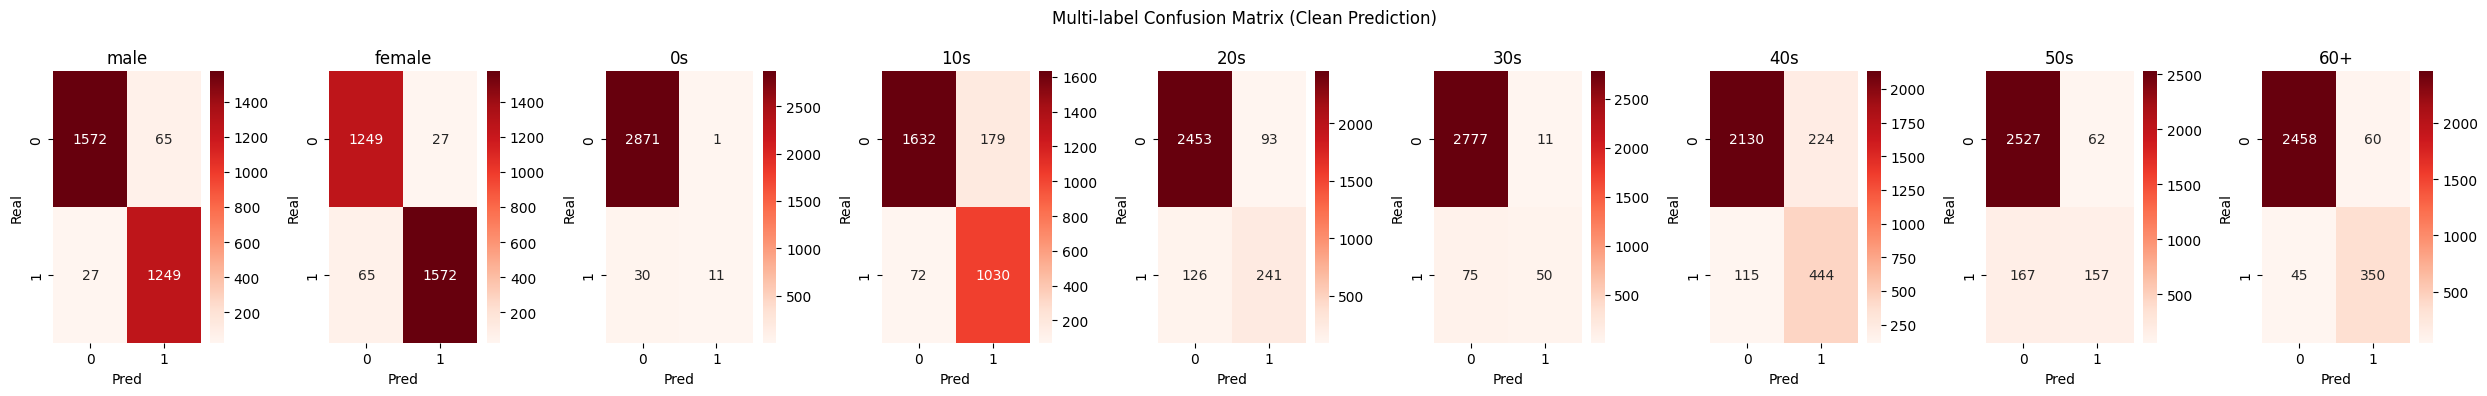

In [ ]:
fig, axes=plt.subplots(1, len(LABEL_COLS), figsize=(25, 4))

for i, label_name in enumerate(LABEL_COLS):
    cm=confusion_matrix(all_labels[:, i], all_preds[:, i])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", ax=axes[i])
    axes[i].set_title(label_name)
    axes[i].set_xlabel("Pred")
    axes[i].set_ylabel("Real")

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, "05_confusion_matrix_clean.jpg"))
plt.show()

# 샘플 이미지

In [ ]:
random.seed(SEED)  # 재현성 고정
indices=random.sample(range(len(all_images)), 10)

plt.figure(figsize=(20, 8))
for i, idx in enumerate(indices):
    img=all_images[idx].permute(1, 2, 0).numpy()
    real_label=all_labels[idx].astype(int)
    pred_label=all_preds[idx].astype(int)

    real_text=[LABEL_COLS[j] for j, v in enumerate(real_label) if v==1]
    pred_text=[LABEL_COLS[j] for j, v in enumerate(pred_label) if v==1]

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"Real: {real_text}\nPred: {pred_text}")
    plt.axis("off")

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, "05_sample_predictions_clean.jpg"), dpi=300)
plt.show()

# 정리
현재 모델의 성별 예측은 안정적이며 연령대는 불균형 문제로 정확도 편차가 존재한다.  
그래프상 과적합도 심하지 않다. 현재 모델은 저장했으니 이를 유지하고 내일 전처리를 개선해보고 다시 진행해볼까 싶다.  

1. Raw 이미지 기준으로 정면(0도) 사진만 필터링한다.  
2. 데이터 통계를 확인해봐서 정제 후 연령대 별 샘플 수를 시각화 한다. 그리고 불균형 정도를 수치로 파악한다.  
3. 증강 설계를 손본다. 소수 클래스의 증강 비율을 높이고 다수 클래스는 증강을 최소화 시키자.  
4. 이렇게 전처리를 완료하면 다시 간단한 CNN 구조로 재학습을 시켜보고, 증강 효과를 비교해볼 예정이다.  